<a href="https://colab.research.google.com/github/terrence-ou/DL_Playground/blob/main/%5BHC%5DAutoEncoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# A Simple AutoEncoder and Latent Space Visualization with PyTorch

## Preliminaries

In [1]:
import os
import random
from PIL import Image

import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchsummary import summary

import numpy as np
import torchvision
from torchvision import transforms

from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("Project running on device: ", DEVICE)

Project running on device:  cpu


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!unzip /content/drive/MyDrive/mni.zip

Archive:  /content/drive/MyDrive/mni.zip
 extracting: mni/MNI_AD1.nii         
 extracting: mni/MNI_AD10.nii        
 extracting: mni/MNI_AD11.nii        
 extracting: mni/MNI_AD12.nii        
 extracting: mni/MNI_AD13.nii        
 extracting: mni/MNI_AD14.nii        
 extracting: mni/MNI_AD15.nii        
 extracting: mni/MNI_AD16.nii        
 extracting: mni/MNI_AD17.nii        
 extracting: mni/MNI_AD18.nii        
 extracting: mni/MNI_AD19.nii        
 extracting: mni/MNI_AD2.nii         
 extracting: mni/MNI_AD20.nii        
 extracting: mni/MNI_AD21.nii        
 extracting: mni/MNI_AD22.nii        
 extracting: mni/MNI_AD23.nii        
 extracting: mni/MNI_AD24.nii        
 extracting: mni/MNI_AD25.nii        
 extracting: mni/MNI_AD26.nii        
 extracting: mni/MNI_AD27.nii        
 extracting: mni/MNI_AD28.nii        
 extracting: mni/MNI_AD29.nii        
 extracting: mni/MNI_AD3.nii         
 extracting: mni/MNI_AD30.nii        
 extracting: mni/MNI_AD31.nii        
 extracti

In [ ]:
import os
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt

def convert_nii_to_png(input_folder, output_folder):
    # Ensure output folder exists
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    # Loop through all files in the input folder
    count = 1
    for filename in os.listdir(input_folder):
        if filename.endswith(".nii") or filename.endswith(".nii.gz"):
            # Load the NIfTI file
            print(f"Processing file {count}")
            if count<139:
              count += 1
              continue
            count += 1
            nii_path = os.path.join(input_folder, filename)
            nii_image = nib.load(nii_path)
            nii_data = nii_image.get_fdata()

            # Assuming we want to convert all slices along the z-axis
            num_slices = nii_data.shape[2]
            print(num_slices)
            for i in range(num_slices):
                # Extract the i-th slice
                # print(f"slice {i}")
                slice_data = nii_data[:, :, i]
                plt.imshow(slice_data.T, cmap='gray', origin='lower')
                output_filename = f"{os.path.splitext(filename)[0]}_slice_{i + 1}.png"
                output_path = os.path.join(output_folder, output_filename)
                plt.savefig(output_path)
                #plt.show()
                # Normalize the slice data to [0, 255] for PNG format
                #slice_data = np.rot90(slice_data)  # Rotate for better viewing
                #slice_data = (255 * (slice_data - np.min(slice_data)) / (np.max(slice_data) - np.min(slice_data))).astype(np.uint8)

                # Save the slice as a PNG file

                #plt.imsave(output_path, slice_data, cmap="gray")
    print("Conversion completed!")

# Example usage
input_folder = "/content/mni"
output_folder = "/content/drive/My Drive/images_of_brain"
convert_nii_to_png(input_folder, output_folder)

Processing file 1
Processing file 2
Processing file 3
Processing file 4
Processing file 5
Processing file 6
Processing file 7
Processing file 8
Processing file 9
Processing file 10
Processing file 11
Processing file 12
Processing file 13
Processing file 14
Processing file 15
Processing file 16
Processing file 17
Processing file 18
Processing file 19
Processing file 20
Processing file 21
Processing file 22
Processing file 23
Processing file 24
Processing file 25
Processing file 26
Processing file 27
Processing file 28
Processing file 29
Processing file 30
Processing file 31
Processing file 32
Processing file 33
Processing file 34
Processing file 35
Processing file 36
Processing file 37
Processing file 38
Processing file 39
Processing file 40
Processing file 41
Processing file 42
Processing file 43
Processing file 44
Processing file 45
Processing file 46
Processing file 47
Processing file 48
Processing file 49
Processing file 50
Processing file 51
Processing file 52
Processing file 53
Pr

## Loading FashionMNIST Dataset

In [ ]:
config = {
    "batch_size": 16,
    "epochs": 20,
    "lr": 5e-4,
}

labels = ["AD", "CN", "MCI", "EMCI", "LMCI"]

In [ ]:
import os
import random
from sklearn.model_selection import train_test_split
from PIL import Image
import torch
from torch.utils.data import DataLoader, Dataset

# Set random seed for reproducibility
random.seed(42)
torch.manual_seed(42)

def collate_fn(batch):
    process = transforms.Compose([
              transforms.Resize((32, 32)),
              transforms.ToTensor(),
              transforms.Normalize((0.5,), (0.5,))
              ])

    x = [process(data[0]) for data in batch]
    x = torch.concat(x).unsqueeze(1)
    # x = x.unsqueeze(0)

    y = torch.LongTensor([data[1] for data in batch])

    return x, y

data_dir = "/content/drive/MyDrive/images_of_brain"
batch_size = 64
val_split = 0.2

# Get all image file paths
all_image_paths = []

for file in os.listdir(data_dir):
    if file.endswith(".png"):
        image = Image.open(os.path.join(data_dir, file))
        if image.mode != "L":
            image = image.convert("L")
        if "AD" in file:
            all_image_paths.append((image,0))
        elif "CN" in file:
            all_image_paths.append((image,1))
        elif "MCI" in file:
            all_image_paths.append((image,2))
        elif "EMCI" in file:
            all_image_paths.append((image,3))
        elif "LMCI" in file:
            all_image_paths.append((image,4))
        else:
          pass

# Split data into training and validation sets
train_dataset, val_dataset = train_test_split(all_image_paths, test_size=val_split, random_state=42)

print(train_dataset[0])

# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
valid_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)

# Print the sizes of the datasets
print(f"Number of training samples: {len(train_loader.dataset)}")
print(f"Number of validation samples: {len(valid_loader.dataset)}")


FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/images_of_brain'

In [ ]:
print("Inspecting train data: ")
for _, data in enumerate(train_loader):
    print("Batch shape: ", data[0].shape)
    fig, ax = plt.subplots(1, 4, figsize=(10, 4))
    for i in range(4):
        ax[i].imshow(data[0][i].squeeze(), cmap="gray")
        ax[i].axis("off")
        ax[i].set_title(labels[data[1][i]])
    plt.show()
    break

Inspecting train data: 


NameError: name 'train_loader' is not defined

## AutoEncoder

Here we implement a mirrored encoder-decoder model

In [ ]:
LAYERS = 3
KERNELS = [3, 3, 3]
CHANNELS = [32, 64, 128]
STRIDES = [2, 2, 2]
LINEAR_DIM = 2048

### Encoder

In [ ]:
class Encoder(nn.Module):

    def __init__(self, output_dim=2, use_batchnorm=False, use_dropout=False):
        super(Encoder, self).__init__()

        # bottleneck dimentionality
        self.output_dim = output_dim

        # variables deciding if using dropout and batchnorm in model
        self.use_dropout = use_dropout
        self.use_batchnorm = use_batchnorm

        # convolutional layer hyper parameters
        self.layers = LAYERS
        self.kernels = KERNELS
        self.channels = CHANNELS
        self.strides = STRIDES
        self.conv = self.get_convs()

        # layers for latent space projection
        self.fc_dim = LINEAR_DIM
        self.flatten = nn.Flatten()
        self.linear = nn.Linear(self.fc_dim, self.output_dim)


    def get_convs(self):
        """
        generating convolutional layers based on
        model's hyper parameters
        """
        conv_layers = nn.Sequential()
        for i in range(self.layers):
            # The input channel of the first layer is 1
            if i == 0: conv_layers.append(nn.Conv2d(1,
                                              self.channels[i],
                                              kernel_size=self.kernels[i],
                                              stride=self.strides[i],
                                              padding=1))

            else: conv_layers.append(nn.Conv2d(self.channels[i-1],
                                         self.channels[i],
                                         kernel_size=self.kernels[i],
                                         stride=self.strides[i],
                                         padding=1))

            if self.use_batchnorm:
                conv_layers.append(nn.BatchNorm2d(self.channels[i]))

            conv_layers.append(nn.GELU()) # Here we use GELU as activation function

            if self.use_dropout:
                conv_layers.append(nn.Dropout2d(0.15))

        return conv_layers


    def forward(self, x):
        x = self.conv(x)
        x = self.flatten(x)
        return self.linear(x)

# Get the summary of autoencoder architecture
encoder = Encoder(use_batchnorm=True, use_dropout=True).to(DEVICE)
summary(encoder, (1, 32, 32))
pass

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 16, 16]             320
       BatchNorm2d-2           [-1, 32, 16, 16]              64
              GELU-3           [-1, 32, 16, 16]               0
         Dropout2d-4           [-1, 32, 16, 16]               0
            Conv2d-5             [-1, 64, 8, 8]          18,496
       BatchNorm2d-6             [-1, 64, 8, 8]             128
              GELU-7             [-1, 64, 8, 8]               0
         Dropout2d-8             [-1, 64, 8, 8]               0
            Conv2d-9            [-1, 128, 4, 4]          73,856
      BatchNorm2d-10            [-1, 128, 4, 4]             256
             GELU-11            [-1, 128, 4, 4]               0
        Dropout2d-12            [-1, 128, 4, 4]               0
          Flatten-13                 [-1, 2048]               0
           Linear-14                   

### Decoder

In [ ]:
class Decoder(nn.Module):
    def __init__(self, input_dim=2, use_batchnorm=False, use_dropout=False):
        super(Decoder, self).__init__()

        # variables deciding if using dropout and batchnorm in model
        self.use_dropout = use_dropout
        self.use_batchnorm = use_batchnorm

        self.fc_dim = LINEAR_DIM
        self.input_dim = input_dim

        # Conv layer hypyer parameters
        self.layers = LAYERS
        self.kernels = KERNELS
        self.channels = CHANNELS[::-1] # flip the channel dimensions
        self.strides = STRIDES

        # In decoder, we first do fc project, then conv layers
        self.linear = nn.Linear(self.input_dim, self.fc_dim)
        self.conv =  self.get_convs()

        self.output = nn.Conv2d(self.channels[-1], 1, kernel_size=1, stride=1)


    def get_convs(self):
        conv_layers = nn.Sequential()
        for i in range(self.layers):

            if i == 0: conv_layers.append(
                            nn.ConvTranspose2d(self.channels[i],
                                               self.channels[i],
                                               kernel_size=self.kernels[i],
                                               stride=self.strides[i],
                                               padding=1,
                                               output_padding=1)
                            )

            else: conv_layers.append(
                            nn.ConvTranspose2d(self.channels[i-1],
                                               self.channels[i],
                                               kernel_size=self.kernels[i],
                                               stride=self.strides[i],
                                               padding=1,
                                               output_padding=1
                                              )
                            )

            if self.use_batchnorm and i != self.layers - 1:
                conv_layers.append(nn.BatchNorm2d(self.channels[i]))

            conv_layers.append(nn.GELU())

            if self.use_dropout:
                conv_layers.append(nn.Dropout2d(0.15))

        return conv_layers


    def forward(self, x):
        x = self.linear(x)
        # reshape 3D tensor to 4D tensor
        x = x.reshape(x.shape[0], 128, 4, 4)
        x = self.conv(x)
        return self.output(x)

decoder = Decoder(use_batchnorm=True, use_dropout=True).to(DEVICE)
summary(decoder, (1, 2))
pass

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1              [-1, 1, 2048]           6,144
   ConvTranspose2d-2            [-1, 128, 8, 8]         147,584
       BatchNorm2d-3            [-1, 128, 8, 8]             256
              GELU-4            [-1, 128, 8, 8]               0
         Dropout2d-5            [-1, 128, 8, 8]               0
   ConvTranspose2d-6           [-1, 64, 16, 16]          73,792
       BatchNorm2d-7           [-1, 64, 16, 16]             128
              GELU-8           [-1, 64, 16, 16]               0
         Dropout2d-9           [-1, 64, 16, 16]               0
  ConvTranspose2d-10           [-1, 32, 32, 32]          18,464
             GELU-11           [-1, 32, 32, 32]               0
        Dropout2d-12           [-1, 32, 32, 32]               0
           Conv2d-13            [-1, 1, 32, 32]              33
Total params: 246,401
Trainable params:

### AutoEncoder

In [ ]:
class AutoEncoder(nn.Module):

    def __init__(self):
        super(AutoEncoder, self).__init__()
        self.encoder = Encoder(output_dim=2, use_batchnorm=True, use_dropout=False)
        self.decoder = Decoder(input_dim=2, use_batchnorm=True, use_dropout=False)

    def forward(self, x):
        return self.decoder(self.encoder(x))

model = AutoEncoder().to(DEVICE)
summary(model, (1, 32, 32))
pass

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 16, 16]             320
       BatchNorm2d-2           [-1, 32, 16, 16]              64
              GELU-3           [-1, 32, 16, 16]               0
            Conv2d-4             [-1, 64, 8, 8]          18,496
       BatchNorm2d-5             [-1, 64, 8, 8]             128
              GELU-6             [-1, 64, 8, 8]               0
            Conv2d-7            [-1, 128, 4, 4]          73,856
       BatchNorm2d-8            [-1, 128, 4, 4]             256
              GELU-9            [-1, 128, 4, 4]               0
          Flatten-10                 [-1, 2048]               0
           Linear-11                    [-1, 2]           4,098
          Encoder-12                    [-1, 2]               0
           Linear-13                 [-1, 2048]           6,144
  ConvTranspose2d-14            [-1, 12

## Experiment

In [ ]:
def plotting(step:int=0, show=False):

    model.eval() # Switch the model to evaluation mode

    points = []
    label_idcs = []

    path = "./ScatterPlots"
    if not os.path.exists(path): os.mkdir(path)

    for i, data in enumerate(valid_loader):
        img, label = [d.to(DEVICE) for d in data]
        # We only need to encode the validation images
        proj = model.encoder(img)
        points.extend(proj.detach().cpu().numpy())
        label_idcs.extend(label.detach().cpu().numpy())
        del img, label

    points = np.array(points)

    # Creating a scatter plot
    fig, ax = plt.subplots(figsize=(10, 10) if not show else (8, 8))
    scatter = ax.scatter(x=points[:, 0], y=points[:, 1], s=2.0,
                c=label_idcs, cmap='tab10', alpha=0.9, zorder=2)

    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)

    if show:
        ax.grid(True, color="lightgray", alpha=1.0, zorder=0)
        plt.show()
    else:
        # Do not show but only save the plot in training
        plt.savefig(f"{path}/Step_{step:03d}.png", bbox_inches="tight")
        plt.close() # don't forget to close the plot, or it is always in memory
        model.train()

In [ ]:
criterion = nn.MSELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=config["lr"], weight_decay=1e-5)

# For mixed precision training
scaler = torch.cuda.amp.GradScaler()
steps = 0 # tracking the training steps

/usr/local/lib/python3.10/dist-packages/torch/amp/grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


In [ ]:
def train(model, dataloader, criterion, optimizer, save_distrib=False):
    # steps is used to track training progress, purely for latent space plots
    global steps

    model.train()
    train_loss = 0.0

    # Process tqdm bar
    batch_bar = tqdm(total=len(dataloader), dynamic_ncols=True,
                     leave=False, position=0, desc="Train")


    for i, batch in enumerate(dataloader):

        optimizer.zero_grad()
        x = batch[0].to(DEVICE)

        # Here we implement the mixed precision training
        with torch.cuda.amp.autocast():
            y_recons = model(x)
            loss = criterion(y_recons, x)

        train_loss += loss.item()

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        batch_bar.set_postfix(
            loss=f"{train_loss/(i+1):.4f}",
            lr = f"{optimizer.param_groups[0]['lr']:.4f}"
        )

        # Saving latent space plots
        if steps % 10 == 0 and save_distrib and steps <= 400: plotting(steps)


        batch_bar.update()
        steps += 1

        torch.cuda.empty_cache()
        del x, y_recons

    batch_bar.close()
    train_loss /= len(dataloader)

    return train_loss

In [ ]:
def validate(model, dataloader, criterion):

    model.eval()
    valid_loss = 0.0

    # Progress tqdm bar
    batch_bar = tqdm(total=len(dataloader), dynamic_ncols=True,
                     leave=False, position=0, desc="Validation")

    for i, batch in enumerate(dataloader):
        x = batch[0].to(DEVICE)

        with torch.no_grad():
            y_recons = model(x)
            loss = criterion(y_recons, x)

        valid_loss += loss.item()

        batch_bar.set_postfix(
            loss=f"{valid_loss/(i+1):.4f}",
            lr = f"{optimizer.param_groups[0]['lr']:.4f}"
        )
        batch_bar.update()

        torch.cuda.empty_cache()
        del x, y_recons

    batch_bar.close()
    valid_loss /= len(dataloader)

    return valid_loss

In [ ]:
# Train the model
for i in range(config["epochs"]):
    curr_lr = float(optimizer.param_groups[0]["lr"])
    train_loss = train(model, train_loader, criterion, optimizer, save_distrib=False) # Turn save_distrib = True if you wish animated latent space
    valid_loss = validate(model, valid_loader, criterion)
    print(f"Epoch {i+1}/{config['epochs']}\nTrain loss: {train_loss:.4f}\t Validation loss: {valid_loss:.4f}\tlr: {curr_lr:.4f}")


Train:   0%|          | 0/26 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Validation:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 1/20
Train loss: 0.4975	 Validation loss: 0.3318	lr: 0.0005


Train:   0%|          | 0/26 [00:00<?, ?it/s]

Validation:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 2/20
Train loss: 0.0762	 Validation loss: 0.0374	lr: 0.0005


Train:   0%|          | 0/26 [00:00<?, ?it/s]

Validation:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 3/20
Train loss: 0.0248	 Validation loss: 0.0211	lr: 0.0005


Train:   0%|          | 0/26 [00:00<?, ?it/s]

Validation:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 4/20
Train loss: 0.0170	 Validation loss: 0.0163	lr: 0.0005


Train:   0%|          | 0/26 [00:00<?, ?it/s]

Validation:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 5/20
Train loss: 0.0144	 Validation loss: 0.0162	lr: 0.0005


Train:   0%|          | 0/26 [00:00<?, ?it/s]

Validation:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 6/20
Train loss: 0.0125	 Validation loss: 0.0120	lr: 0.0005


Train:   0%|          | 0/26 [00:00<?, ?it/s]

Validation:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 7/20
Train loss: 0.0111	 Validation loss: 0.0105	lr: 0.0005


Train:   0%|          | 0/26 [00:00<?, ?it/s]

Validation:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 8/20
Train loss: 0.0102	 Validation loss: 0.0092	lr: 0.0005


Train:   0%|          | 0/26 [00:00<?, ?it/s]

Validation:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 9/20
Train loss: 0.0099	 Validation loss: 0.0110	lr: 0.0005


Train:   0%|          | 0/26 [00:00<?, ?it/s]

Validation:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 10/20
Train loss: 0.0096	 Validation loss: 0.0086	lr: 0.0005


Train:   0%|          | 0/26 [00:00<?, ?it/s]

Validation:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 11/20
Train loss: 0.0091	 Validation loss: 0.0081	lr: 0.0005


Train:   0%|          | 0/26 [00:00<?, ?it/s]

Validation:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 12/20
Train loss: 0.0087	 Validation loss: 0.0078	lr: 0.0005


Train:   0%|          | 0/26 [00:00<?, ?it/s]

Validation:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 13/20
Train loss: 0.0082	 Validation loss: 0.0075	lr: 0.0005


Train:   0%|          | 0/26 [00:00<?, ?it/s]

Validation:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 14/20
Train loss: 0.0080	 Validation loss: 0.0073	lr: 0.0005


Train:   0%|          | 0/26 [00:00<?, ?it/s]

Validation:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 15/20
Train loss: 0.0079	 Validation loss: 0.0072	lr: 0.0005


Train:   0%|          | 0/26 [00:00<?, ?it/s]

Validation:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 16/20
Train loss: 0.0078	 Validation loss: 0.0071	lr: 0.0005


Train:   0%|          | 0/26 [00:00<?, ?it/s]

Validation:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 17/20
Train loss: 0.0076	 Validation loss: 0.0067	lr: 0.0005


Train:   0%|          | 0/26 [00:00<?, ?it/s]

Validation:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 18/20
Train loss: 0.0074	 Validation loss: 0.0066	lr: 0.0005


Train:   0%|          | 0/26 [00:00<?, ?it/s]

Validation:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 19/20
Train loss: 0.0072	 Validation loss: 0.0065	lr: 0.0005


Train:   0%|          | 0/26 [00:00<?, ?it/s]

Validation:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 20/20
Train loss: 0.0072	 Validation loss: 0.0065	lr: 0.0005


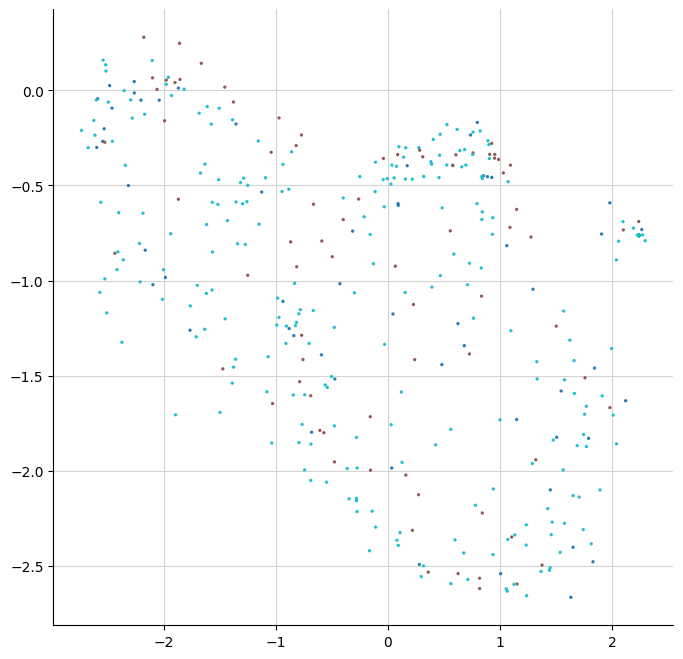

In [ ]:
# Plotting the latent space
plotting(show=True)

In [ ]:
# convert png images to gif
frames = []
imgs = sorted(os.listdir("./ScatterPlots"))

for im in imgs:
    new_frame = Image.open("./ScatterPlots/" + im)
    frames.append(new_frame)

frames[0].save("latentspace.gif", format="GIF",
               append_images=frames[1:],
               save_all=True,
               duration=200, loop=0)

IndexError: list index out of range

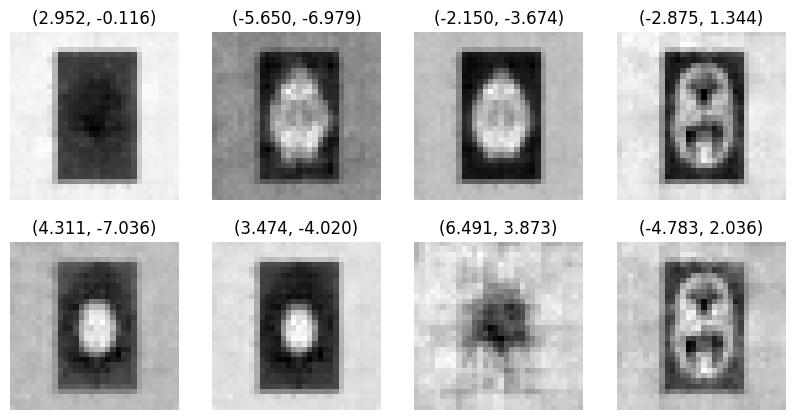

In [ ]:
# randomly sample x and y values
xs = [random.uniform(-6.0, 8.0) for i in range(8)]
ys = [random.uniform(-7.5, 10.0) for i in range(8)]

points = list(zip(xs, ys))
coords = torch.tensor(points).unsqueeze(1).to(DEVICE)

nrows, ncols = 2, 4
fig, axes = plt.subplots(nrows, ncols, figsize=(10, 5))

model.eval()
with torch.no_grad():
    generates = [model.decoder(coord) for coord in coords]

# plot points
idx = 0
for row in range(0, nrows):
    for col in range(0, ncols):
        ax = axes[row, col]
        im = generates[idx].squeeze().detach().cpu()
        ax.imshow(im, cmap="gray")
        ax.axis("off")
        coord = coords[idx].detach().cpu().numpy()[0]
        ax.set_title(f"({coord[0]:.3f}, {coord[1]:.3f})")
        idx += 1
plt.show()
